# 0. Imports & functions

In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/telco_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
# df = pd.read_csv(RAW_DATA_PATH)
# df = df.rename(columns=dict(
#     zip(df.columns, list(map(to_snake_case, df.columns)))))

# print(df.shape[0])
# df.churn.value_counts()/df.shape[0]*100

In [4]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(
    0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
               'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category",
                   "churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

# 2. Model selection

## Logistic Regression

In [5]:
df[y].value_counts()/len(df)

customer_status
Stayed     0.716345
Churned    0.283655
Name: count, dtype: float64

In [6]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = "logistic"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name=MODEL_NAME, param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1260 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^

Best score: 0.9136876006441224
Best parameters: {'logistic__C': 10, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 50, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'streaming_music',
                                                   'unlimited_data', 'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=50)),
                ('logistic', LogisticRegression(C=10))])

In [7]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [8]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
29,0.5,0.7,15,1,l2,0.874857,0.007814
113,0.5,0.7,15,10,l2,0.874506,0.006939
197,0.5,0.7,15,100,l2,0.874586,0.007126
281,0.5,0.7,15,1000,l2,0.874128,0.007080
33,0.5,0.7,20,1,l2,0.875266,0.006538
...,...,...,...,...,...,...,...
330,0.7,1.0,50,1000,l2,0.912819,0.007636
82,0.7,1.0,65,1,l2,0.913639,0.005008
166,0.7,1.0,65,10,l2,0.913405,0.004664
250,0.7,1.0,65,100,l2,0.911937,0.006697


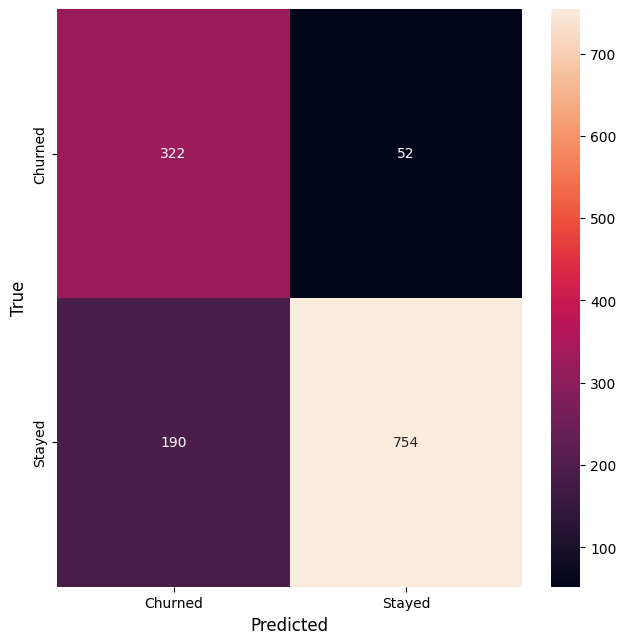

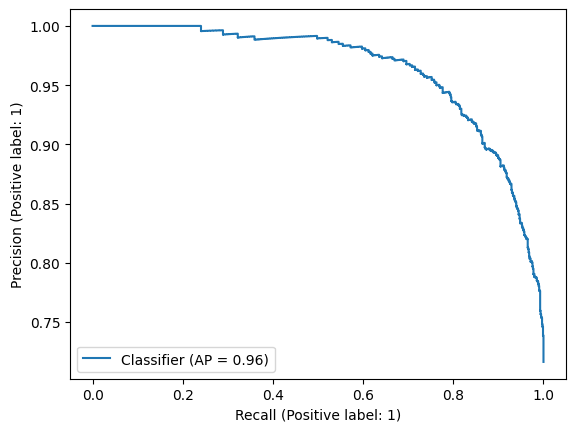

In [9]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [10]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8959211480950613
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 15, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [11]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

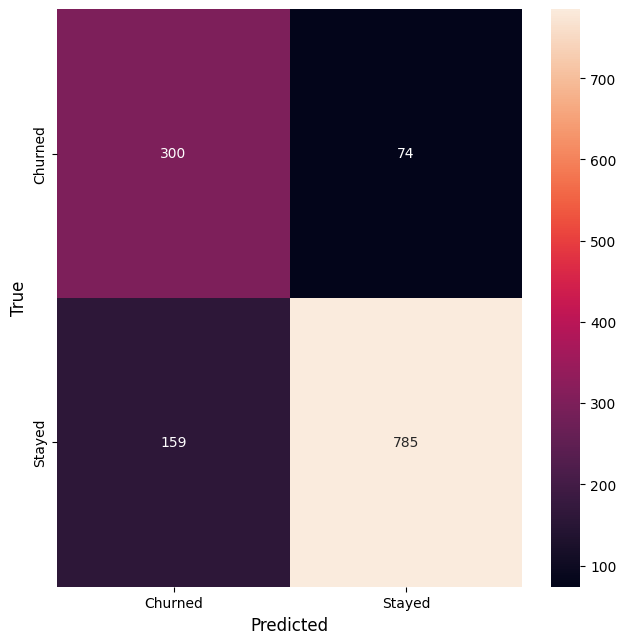

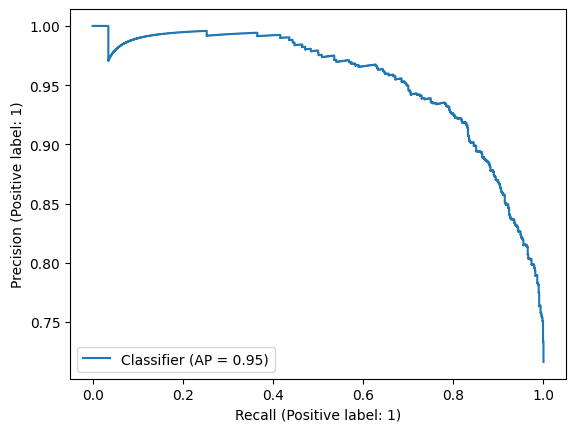

In [12]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [43]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# 3. Cost-based evaluation

In [44]:
# Define a function to calculate the instance-dependent cost

def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 0       # Switched cost for TN
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
        return  12 * a  # Switched cost for FP
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 0  

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["customer_status"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["monthly_charge"]).to_frame())[:, 0]
test_predictions["y_predicted"] = 1 - test_predictions["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")



Test cost/loss = 68125.


In [45]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 0       # Switched cost for TN
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)
        return  12 * a  # Switched cost for FP
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 0  

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["customer_status"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["monthly_charge"]).to_frame())[:, 0]
test_predictions_xgb["y_predicted"] = 1 - test_predictions_xgb["y_predicted"]
# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['customer_status', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")



Test cost/loss = 78328.


In [46]:
print(test_predictions[['customer_status', "A", 'instance_cost', "y_predicted"]].head(30))

     customer_status       A  instance_cost  y_predicted
4879          Stayed   67.45            0.0            0
1646          Stayed   69.65            0.0            0
777           Stayed   20.10            0.0            0
1163          Stayed   54.75            0.0            0
130           Stayed   48.80            0.0            0
1837          Stayed   19.90            0.0            0
302           Stayed   20.05            0.0            0
768           Stayed   39.40            0.0            0
1058          Stayed   99.00            0.0            0
1141          Stayed   19.80            0.0            0
2348          Stayed   19.95            0.0            0
5058          Stayed   47.05            0.0            0
6291          Stayed   20.05            0.0            0
4939          Stayed   75.95          151.9            1
2862          Stayed   76.20          152.4            1
4216          Stayed   84.30          168.6            1
4068          Stayed   79.45   

# 3.1 E-AMC evaluation metric

In [47]:
print(test[y])
train[y].value_counts()
label_mapper = {'Stayed': 0, 'Churned': 1}
train['y_encoded'] = train[y].map(label_mapper)
test['y_encoded'] = test[y].map(label_mapper)
print(test['y_encoded'])


4879     Stayed
1646     Stayed
777      Stayed
1163     Stayed
130      Stayed
         ...   
3969    Churned
2993    Churned
3373    Churned
4476    Churned
2641    Churned
Name: customer_status, Length: 1318, dtype: object
4879    0
1646    0
777     0
1163    0
130     0
       ..
3969    1
2993    1
3373    1
4476    1
2641    1
Name: y_encoded, Length: 1318, dtype: int64


In [48]:
# train[y].value_counts()
# label_mapper = {'Stayed': 0, 'Churned': 1}
# train['y_encoded'] = train[y].map(label_mapper)
# test['y_encoded'] = test[y].map(label_mapper)

cb_column = 'cb'
test[cb_column]=(test["monthly_charge"])

test['TN'] = 2* test[cb_column]
test['FN'] = 0
test['FP'] = 0
test['TP'] = 12* test[cb_column]

test = add_eap_ep(train, test, 'y_encoded', best_pipeline_log_reg, cb_column)

test_xgb = add_eap_ep(train, test, 'y_encoded', best_pipeline_xgb, cb_column)



c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [49]:
pd.set_option('display.max_columns', None)

test

,gender,age,married,number_of_dependents,zip_code,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,cb,TN,FN,FP,TP,y_encoded,prob_churn,EAP,EP,y_predicted_proba,instance_cost,churn_encoded
4879,Male,28,No,0,94612,0,40,NaN,Yes,39.05,No,Yes,DSL,58.0,Yes,No,Yes,No,No,Yes,Yes,Yes,Month-to-Month,No,Bank Withdrawal,67.45,2731.00,0.0,0,1562.00,4293.00,Stayed,67.45,134.9,0,0,809.4,0,0.917659,44.796113,96.638664,0.667931,809.4,1
1646,Male,25,Yes,0,93212,6,50,Offer B,Yes,14.32,Yes,Yes,Cable,58.0,No,No,Yes,Yes,Yes,No,No,Yes,One Year,Yes,Bank Withdrawal,69.65,3442.15,0.0,0,716.00,4158.15,Stayed,69.65,139.3,0,0,835.8,0,0.929044,5.236780,99.790704,0.962406,835.8,1
777,Female,38,No,0,93552,0,18,Offer D,Yes,18.80,No,No,no internet service,0.0,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,One Year,No,Mailed Check,20.10,407.05,0.0,0,338.40,745.45,Stayed,20.10,40.2,0,0,241.2,0,0.931250,4.699539,28.798179,0.883096,241.2,1
1163,Female,51,No,0,92220,0,42,NaN,No,0.00,no phone service,Yes,DSL,13.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One Year,Yes,Bank Withdrawal,54.75,2348.45,0.0,80,0.00,2428.45,Stayed,54.75,109.5,0,0,657.0,0,0.949495,9.006418,78.442800,0.917750,657.0,1
130,Male,69,No,0,95820,0,52,Offer B,No,0.00,no phone service,Yes,DSL,19.0,Yes,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,48.80,2555.05,0.0,0,0.00,2555.05,Stayed,48.80,97.6,0,0,585.6,0,0.988306,3.364229,69.917966,0.965530,585.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Female,44,Yes,0,93437,1,20,NaN,No,0.00,no phone service,Yes,DSL,10.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,24.45,482.80,0.0,0,0.00,482.80,Churned,24.45,48.9,0,0,293.4,1,0.080460,47.410449,83.216278,0.161590,0.0,0
2993,Male,54,Yes,0,93637,1,40,Offer B,Yes,22.56,Yes,Yes,Cable,4.0,No,Yes,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,101.30,4113.10,0.0,0,902.40,5015.50,Churned,101.30,202.6,0,0,1215.6,1,0.134841,45.385283,344.777462,0.037336,0.0,0
3373,Female,64,Yes,0,92320,1,1,Offer E,Yes,21.65,No,Yes,Fiber Optic,13.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,68.95,68.95,0.0,0,21.65,90.60,Churned,68.95,137.9,0,0,827.4,1,0.008066,15.869969,234.673307,0.019181,0.0,0
4476,Female,54,No,0,91202,0,1,Offer E,No,0.00,no phone service,Yes,DSL,27.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,29.95,29.95,0.0,0,0.00,29.95,Churned,29.95,59.9,0,0,359.4,1,0.155531,38.220831,101.935686,0.106346,0.0,0


In [50]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

101980.20202846802
175897.05035097705
EAP :  77.37496360278301
EP :  133.4575495834424


In [51]:
print(test_xgb['EAP'].sum())
print(test_xgb['EP'].sum())


print('EAP : ', test_xgb['EAP'].sum()/len(test))
print('EP : ', test_xgb['EP'].sum()/len(test))

110269.66229927226
175897.05035097705
EAP :  83.66438717698958
EP :  133.4575495834424


# 3.2 AMC evaluation metric

Decision Threshold: 0.01, Test cost/loss = 53465.80
Decision Threshold: 0.02, Test cost/loss = 53148.90
Decision Threshold: 0.03, Test cost/loss = 51415.50
Decision Threshold: 0.04, Test cost/loss = 48718.70
Decision Threshold: 0.05, Test cost/loss = 46813.70
Decision Threshold: 0.06, Test cost/loss = 46379.40
Decision Threshold: 0.07, Test cost/loss = 47032.70
Decision Threshold: 0.08, Test cost/loss = 44175.20
Decision Threshold: 0.09, Test cost/loss = 44430.00
Decision Threshold: 0.10, Test cost/loss = 47339.10
Decision Threshold: 0.11, Test cost/loss = 52018.30
Decision Threshold: 0.12, Test cost/loss = 57071.50
Decision Threshold: 0.13, Test cost/loss = 57145.80
Decision Threshold: 0.14, Test cost/loss = 59771.50
Decision Threshold: 0.15, Test cost/loss = 63917.00
Decision Threshold: 0.16, Test cost/loss = 66597.70
Decision Threshold: 0.17, Test cost/loss = 69214.00
Decision Threshold: 0.18, Test cost/loss = 71803.90
Decision Threshold: 0.19, Test cost/loss = 73279.90
Decision Thr

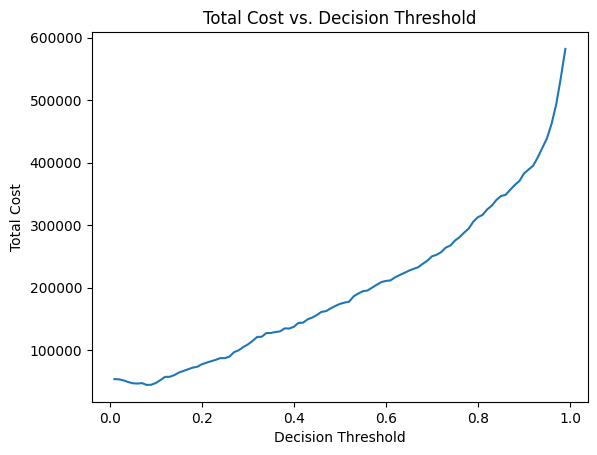

(0.08, 33.51684370257966, 44175.2)

In [52]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, 'y_encoded', 'cb')


Decision Threshold: 0.01, Test cost/loss = 52054.60
Decision Threshold: 0.02, Test cost/loss = 48796.40
Decision Threshold: 0.03, Test cost/loss = 47261.60
Decision Threshold: 0.04, Test cost/loss = 46593.10
Decision Threshold: 0.05, Test cost/loss = 46663.50
Decision Threshold: 0.06, Test cost/loss = 47983.50
Decision Threshold: 0.07, Test cost/loss = 46153.90
Decision Threshold: 0.08, Test cost/loss = 47620.40
Decision Threshold: 0.09, Test cost/loss = 49867.40
Decision Threshold: 0.10, Test cost/loss = 54968.30
Decision Threshold: 0.11, Test cost/loss = 57171.00
Decision Threshold: 0.12, Test cost/loss = 59400.30
Decision Threshold: 0.13, Test cost/loss = 64343.20
Decision Threshold: 0.14, Test cost/loss = 67146.60
Decision Threshold: 0.15, Test cost/loss = 68752.20
Decision Threshold: 0.16, Test cost/loss = 70118.60
Decision Threshold: 0.17, Test cost/loss = 73080.30
Decision Threshold: 0.18, Test cost/loss = 76606.60
Decision Threshold: 0.19, Test cost/loss = 77921.90
Decision Thr

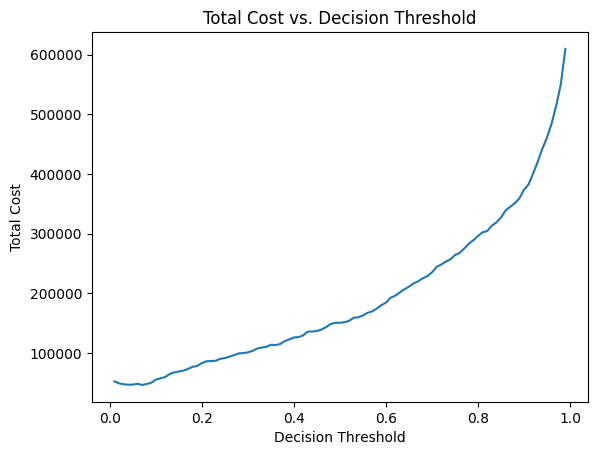

(0.06999999999999999, 35.0181335356601, 46153.90000000001)

In [53]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_xgb['y_predicted_proba']= xgb_best.predict_proba(test_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_xgb['instance_cost'] = test_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_xgb, best_pipeline_xgb, 'y_encoded', 'cb')

# 3.3 EMP evaluation metric

# emp and mp


In [54]:
df['total_revenue'].mean()

3235.2180816512373

In [60]:
test_xgb = test.copy(deep=True)
test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
test_xgb["churn_encoded"] = fit_le.transform(test_xgb["customer_status"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_xgb['y_predicted_proba'], test_xgb["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1




In [61]:

test_xgb = test.copy(deep=True)
test_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_xgb.drop(y, axis=1))[:, 1]
test_xgb["churn_encoded"] = fit_le.transform(test_xgb["customer_status"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test["y_predicted_proba"], test["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_xgb["y_predicted_proba"], test_xgb["churn_encoded"], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_15796\4038183274.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=689.3801213960546, MP_fraction=0.023520485584218487, EMP=689.3805316050233, EMP_fraction=0.02374954177400712)

In [58]:
test = test.copy(deep=True)
test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
test["churn_encoded"] = fit_le.transform(test["customer_status"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test['y_predicted_proba'], test["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1

In [59]:
test = test.copy(deep=True)
test["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test.drop(y, axis=1))[:, 1]
test["churn_encoded"] = fit_le.transform(test["customer_status"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test["y_predicted_proba"], test["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction =1-( roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E])

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction =1-( np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1)))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test["y_predicted_proba"], test["churn_encoded"], alpha=6, beta=14, clv=3235, d=10, f=1, print_output=False, return_output=True, rounding=None)

C:\Users\stijn\AppData\Local\Temp\ipykernel_15796\2672661407.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=689.4552352048559, MP_fraction=0.030349013657056112, EMP=689.4552381618599, EMP_fraction=0.030350928525928134)